In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, json, shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow import keras

import os
import json
import sys

import datetime
import os
import time

from itertools import islice


train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/interim/Vegas/train'
val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/interim/Vegas/val'

out_train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'
out_val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


sources to help this notebook run  
https://keras.io/examples/vision/oxford_pets_image_segmentation/  

In [ ]:
class PrePixer(object):
    def __init__(self, img_dir, dump_dir, mode, chunk_size , img_size):
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        
        self.out_img_dir = dump_dir + "/images"
        self.out_mask_dir = dump_dir + "/masks"
        
        self.mode = mode
        self.chunk_size = chunk_size
        self.img_size = img_size
        
        self.data_gen_args = dict(rescale=1./255,
                     rotation_range=40,
                     horizontal_flip=True)

        self.image_datagen = ImageDataGenerator(**self.data_gen_args)
        self.mask_datagen = ImageDataGenerator(**self.data_gen_args)

  # crate a list of batches based on the total file and desired batch size
    def chunk(self, it, size):
        it = iter(it)
        return iter(lambda: tuple(islice(it, size)), ())

    def pre_pixer(self):  
        # select the file directory
        _img_dir = self.img_dir 
        _mask_dir = self.mask_dir 

        # list all the image files
        img_list = os.listdir(_img_dir)
        # select the file bese on minimum to have 50-50 proportion
        min_len = min([len(img_list)])
        img_list = [{"file_name":item, "label":0} for item in img_list if ".png" in item][: int(min_len)]
        file_list = img_list
        total_len = len(file_list)

        # create list of list based on batch size parameter
        chunks = list(self.chunk(file_list, self.chunk_size))
        
        for idx, meta_files in enumerate(chunks, 1):
            X_file = []
            y_file = []
            batch_size_i = len(meta_files)
        
            #take each image and convert to numpy array
            for item in meta_files:
                label, file_name = item.get("label"), item.get("file_name")
                img_path_i = os.path.join(_img_dir, file_name)
                mask_path_i = os.path.join(_mask_dir, file_name)

                img_i = load_img(img_path_i, target_size=self.img_size, color_mode="rgb")
                img_i = img_to_array(img_i)
                exp_img = np.expand_dims(img_i, axis=0)
                X_file.append(exp_img)

                mask_i = load_img(mask_path_i, target_size=self.img_size , color_mode="grayscale")
                mask_i = img_to_array(mask_i)
                exp_mask = np.expand_dims(mask_i, axis=0)
                y_file.append(exp_mask)

            # a batch of numpy array
            X_file = np.concatenate(X_file)
            y_file = np.concatenate(y_file)
        
            # for validaton we do not need to augment the file so we will save them directly
            if self.mode == "val":
                x_file_name = "image_file_{}.npy".format(idx)
                y_file_name = "label_file_{}.npy".format(idx)
                np.save(os.path.join(self.out_img_dir, x_file_name), X_file)
                np.save(os.path.join(self.out_mask_dir, y_file_name), y_file)
                print("Done batch for validation {}/{}".format(idx, len(chunks)))

          # for train we will have a augmented file of each image
            elif self.mode == "train":
                image_flow = self.image_datagen.flow(
                    X_file,
                    shuffle=False,
                    seed=12,
                    batch_size=32)

                aug_x_set = []
                for aug_x in image_flow:
                    aug_x_set.append(aug_x)
                    break
                aug_x_set = np.concatenate(aug_x_set)

                mask_flow = self.mask_datagen.flow(
                    y_file,
                    shuffle=False,
                    seed=12,
                    batch_size=32)

                aug_y_set = []
                for aug_y in mask_flow:
                    aug_y_set.append(aug_y)
                    break
                aug_y_set = np.concatenate(aug_y_set)

                x_file_name = "image_file_{}.npy".format(idx)
                y_file_name = "label_file_{}.npy".format(idx)

                np.save(os.path.join(self.out_img_dir, x_file_name), aug_x_set)
                np.save(os.path.join(self.out_mask_dir, y_file_name), aug_y_set)

                print("Done batch for train {}/{}".format(idx, len(chunks)))
            else:
                raise Exception("Only <val> or <train> is available as parameter")
        return print("DB Created")

In [ ]:
pxer = PrePixer(train_data_dir,out_train_data_dir, mode="train", chunk_size=32 , img_size = (512,512))
# pxer.pre_pixer()

In [ ]:
pxer = PrePixer(val_data_dir,out_val_data_dir, mode="val", chunk_size=32 , img_size = (512,512))
# pxer.pre_pixer()

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(18, 9))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,5):
    
    image = X_file[a]

    # Load masks
    mask = y_file[a]
    
    
    axes[0, a].imshow( image / 255.0)
    axes[1, a].imshow( mask / 255.0)

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(18, 9))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,5):
    
    image = aug_x_set[a]

    # Load masks
    mask = aug_y_set[a]
    
    
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [2]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))    

    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y
        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            # Store class
            y = np.load(y_file_path)
        return X, y    

In [29]:
# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================

all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))}
val_partition = [item for item in all_val_files if "image_file" in item]

In [32]:
train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

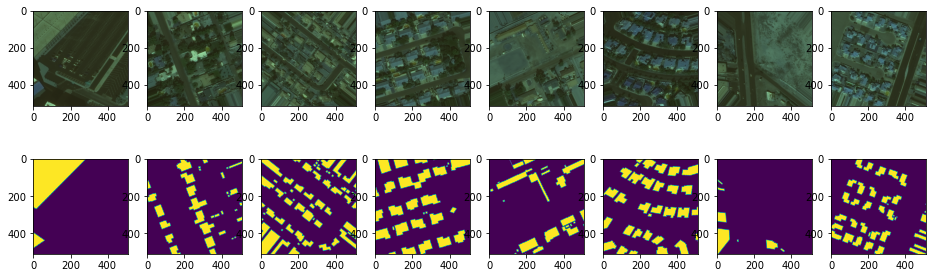

In [37]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = train_generator[5][0][a+5,:,:,:]

    # Load masks
    mask = train_generator[5][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [40]:
batch_size = 31
def timeit(ds, steps=90):
        """
        Check performance/speed for loading images using Keras or tfdata.
        """
        start = time.time()
        it = iter(ds)
        for i in range(steps):
            next(it)
            print('   >> ', i, '/90', end='\r')
        duration = time.time()-start
        print(f'''{steps} batches: '''
                f'''{datetime.timedelta(seconds=int(duration))}''')
        print(f'{round(batch_size*steps/duration)} Images/s')


In [42]:
timeit(train_generator)

90 batches: 0:00:08
323 Images/s


In [52]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((512,512), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [54]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

# callbacks = [
#     keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
# ]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_generator, epochs=5, validation_data=val_generator, use_multiprocessing=True)


# model.fit_generator(
#     train_generator,
#     steps_per_epoch=int(len(train_generator) // train_generator.batch_size), 
#     epochs=20,
#     max_queue_size=35,
#     workers=35,
#     use_multiprocessing=True,
#     shuffle=False,
#     callbacks=[noise_cb, tqdm_cb],
#     verbose=0,
# )

Epoch 1/5


ResourceExhaustedError:  OOM when allocating tensor with shape[32,512,512,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node model/conv2d_7/BiasAdd (defined at <ipython-input-54-1bfb1dae84e9>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_18764]

Function call stack:
train_function
